In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import os
import datetime


import import_ipynb
from TrulyPlastic_allOpt_3 import plastic_nn
from TrulyPlastic_allOpt_3 import input_layer
from TrulyPlastic_allOpt_3 import layer

importing Jupyter notebook from TrulyPlastic_allOpt_3.ipynb


In [3]:
#np.random.seed(42)
#random.seed(42)

In [4]:

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)




class DQN():
    # Hyperparameters (adjustable)
    def __init__(s, ct, path = r'test', game_name = 'MountainCar-v0', discount_factor_g = 0.9, 
                 mini_batch_size = 32, 
                  num_divisions = 20, replay_memory_size = 100000, network_sync_rate = 50000):
        s.ct = ct
        
        s.path = path
        current_directory = os.getcwd()
        final_directory = os.path.join(current_directory, s.path)
        if not os.path.exists(final_directory):
            os.makedirs(final_directory)
    
        s.game_name = game_name
        s.discount_factor_g = discount_factor_g
         
        s.mini_batch_size = mini_batch_size 
        s.num_divisions = num_divisions

        s.replay_memory_size =  replay_memory_size 
        s.network_sync_rate = network_sync_rate
        
    
    def plot_progress(self, rewards_per_episode, epsilon_history):
        
        plt.figure(1)
        plt.subplot(121) 
        plt.subplots_adjust(wspace=0.5, hspace=0.3)
        
        plt.xlabel('epochs')
        plt.ylabel('reward')
        plt.plot(rewards_per_episode)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.xlabel('epochs')
        plt.ylabel('epsilon')
        plt.plot(epsilon_history)
        plt.savefig(f'{self.path}/info_{self.ct}.png'.format(self.path, self.ct))

    

    def train(self, policy_dqn, target_dqn, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make(self.game_name, render_mode='human' if render else None)

        #env.action_space.seed(42)
        
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        rewards_per_episode = []
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count = 0
        goal_reached = False
        best_rewards = -200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0 seed=int(i+10)
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False
            rewards = 0

            while(not terminated and rewards > -1000):
                if random.random() < epsilon:
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    res = policy_dqn.forward(self.state_to_dqn_input(state))
                    action = res.argmax().item()

                new_state,reward,terminated,truncated,_ = env.step(action)
                rewards += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state
                
                step_count+=1


            rewards_per_episode.append(rewards)
            
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')
                policy_dqn.save(f'{self.path}/mc_policy_{i}'.format(self.path, i))
                self.add_log_data(f'Episode {i} Epsilon {epsilon}')
                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                self.add_log_data(f'Best rewards so far: {best_rewards}')
                policy_dqn.save(f'{self.path}/mc_policy_{i}'.format(self.path, i))
                

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                
                #print(f'OPTIMIZE Episode {i} Epsilon {epsilon} rewards {rewards}') # print(rewards)

                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = epsilon = max(epsilon - 1/episodes, 0.01) # max(epsilon*0.99996, 0.05)#
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn = policy_dqn.deep_copy()
                    step_count = 0
                   
                
                
        env.close()
        policy_dqn.save(f'{self.ct}/mc_policy_last'.format(ct))
        print(rewards_per_episode)



    
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        target_q_list = []
        input_list = []
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                target = reward
            else:
                target = reward + self.discount_factor_g * target_dqn.forward(self.state_to_dqn_input(new_state)).max()

            # Get the target set of Q values
            state_dsc = np.asarray(self.state_to_dqn_input(state))
            input_list.append(state_dsc)
            
            target_q = target_dqn.forward(state_dsc)
            
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target            
            target_q_list.append(target_q)

        #BACKPOP AND UPDATE on minibatch
        x = np.asarray(input_list)
        x = x[:, :, 0]
        x = x.T

        y = np.asarray(target_q_list)
        y = y[:, :, 0]
        y = y.T

        policy_dqn.learn_one(x, y)



    def state_to_dqn_input(self, state):
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)
        
        # state_p = state[0]
        # state_v = state[1]

        return np.asarray([[state_p], [state_v]])

        

    def test(self, policy_dqn, episodes, render = False):
        env = gym.make(self.game_name, render_mode='human' if render else None)
        
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        done_count = 0
        
        for i in range(episodes):
            state, info = env.reset()  # Initialize to state 0
            done = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not done and not truncated):
                state = self.state_to_dqn_input(state)
                #print('state shape', state.shape)
               
                res = policy_dqn.forward(state)

                action = res.argmax().item()
                #print(res)
                state, reward, done, truncated, _ = env.step(action)
                if (done):
                    done_count += 1

        print(done_count/episodes)
        env.close()

    def save_info(s, ct, topology):
        file_path = f'{s.path}/info.txt'.format(s.path)
        f = open(file_path, "a")   
       


        f.write("{}\n".format(s.ct))
        
        f.write("{}\n".format(s.game_name))
        f.write("{}\n".format(s.discount_factor_g))
        f.write("{}\n".format(s.mini_batch_size))
        f.write("{}\n".format(s.num_divisions))
        f.write("{}\n".format(s.replay_memory_size))
        f.write("{}\n".format(s.network_sync_rate))
        f.write("{}\n".format(topology))
                         
        f.close()
    
    def add_log_data(s, data):
        file_path = f'{s.path}/info.txt'.format(s.path)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()


In [5]:
learning_rate_a = 0.0001
in_states = 2
h1_nodes = 32
h2_nodes = 32
out_actions = 3

a_type1 = 'ReLU'
a_type2 = 'Linear'

layers_net = [input_layer(in_states), 
layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_type1), 
layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_type1), 
layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_type2)]

policy_dqn = plastic_nn(optimizer="Adam")
policy_dqn.append_layers(layers_net)

target_dqn = plastic_nn()
target_dqn = policy_dqn.deep_copy()


added LAYERS succesfully


In [6]:
ct = datetime.datetime.now()
ct = str(ct)
ct = ct.replace(":", "-")
ct = ct.replace(" ", "_")
ct = ct[:-7]

In [7]:

mountaincar = DQN(ct, path = ct, game_name = 'MountainCar-v0', discount_factor_g = 0.9, mini_batch_size = 64, 
                  num_divisions = 50, replay_memory_size = 100000, network_sync_rate = 50000)


Episode 1000 Epsilon 0.9819199999999819
Episode 2000 Epsilon 0.9419199999999419
Episode 3000 Epsilon 0.9019199999999019
Episode 4000 Epsilon 0.8619199999998619
Episode 5000 Epsilon 0.8219199999998219
Episode 6000 Epsilon 0.7819199999997819
Episode 7000 Epsilon 0.7419199999997419
Episode 8000 Epsilon 0.7019199999997019
Episode 9000 Epsilon 0.6619199999996619
Episode 10000 Epsilon 0.6219199999996219
Episode 11000 Epsilon 0.5819199999995819
Episode 12000 Epsilon 0.5419199999995419
Episode 13000 Epsilon 0.5019199999995019
Episode 14000 Epsilon 0.4619199999995148
Episode 15000 Epsilon 0.4219199999995303
Episode 16000 Epsilon 0.3819199999995458
Episode 17000 Epsilon 0.3419199999995613
Episode 18000 Epsilon 0.3019199999995768
Episode 19000 Epsilon 0.2619199999995923
Episode 20000 Epsilon 0.2219199999995883
Episode 21000 Epsilon 0.18191999999957606
Episode 22000 Epsilon 0.1419199999995638
Episode 23000 Epsilon 0.10191999999955959
Episode 24000 Epsilon 0.061919999999561215
[-1000.0, -1000.0, -1

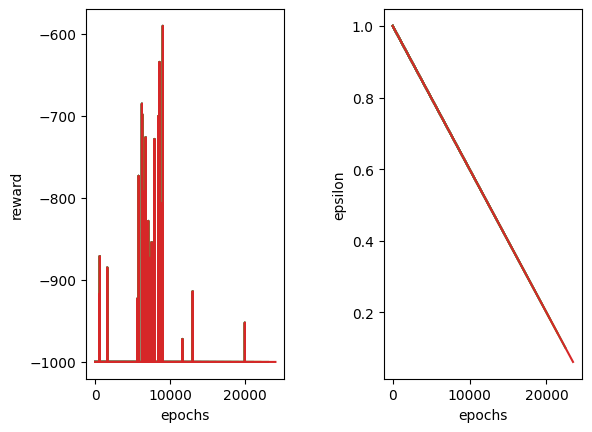

In [8]:
mountaincar.save_info(ct, f'lr: {learning_rate_a} \nin:{in_states} \nh:{h1_nodes}x2 (--) \nout:{out_actions} \na1:{a_type1} \na2:{a_type2} \n'.format(
    learning_rate_a, in_states, h1_nodes, out_actions, a_type1, a_type2))
mountaincar.train(policy_dqn, target_dqn, 25000, False)


In [9]:
#myADAM_andENV/31_05/2024-05-31_12-45-39/mc_policy_last

In [10]:
#policy_dqn.load(f'{ct}/mc_policy_24204') #f'{ct}/mc_policy_21560'

In [15]:
#policy_dqn.load('2024-05-31_12-45-39/mc_policy_last ') #f'{ct}/mc_policy_21560'

FileNotFoundError: [Errno 2] No such file or directory: 'myADAM_andENV/01_06x2/2024-06-01_19-01-18/04_04_00/mc_policy_4785'

In [12]:
#mountaincar.test(policy_dqn, 3, render = True)

In [13]:
#policy_dqn.print_info()

In [14]:
#policy_dqn.print_info()